## Comparing pyclesperanto and OPM deskewing results

Pyclesperanto deskewing shows artefacts due to composing a single affine transformation for shearing and rotation. Comparing this to the OPM implementation by Doug Shepherd. 

It appears that the OPM code doesn't have artefacts as it processes plane by plane and performs interpolation between them.

In [1]:
from numba import njit, prange
import numpy as np
import napari 
import pyclesperanto_prototype as cle
from skimage.io import imread


img = imread("../sample_data/RBC_lattice.tif")

voxel_size_x_in_microns = 0.1449922
voxel_size_y_in_microns = 0.1449922
voxel_size_z_in_microns = 0.3

deskewing_angle_in_degrees = 30

print("Shape of original image", img.shape )

#make data highly anisotropic 
#keep every 4th slice
image_anisotropic = img[::4]
#scale voxel size in z direction 4 times 
voxel_size_z_anisotropic = voxel_size_z_in_microns * 4

print("Shape of anisotropic image", image_anisotropic.shape )

Shape of original image (150, 118, 209)
Shape of anisotropic image (38, 118, 209)


In [2]:
#Perform deskewing on original image  
deskewed_cle = cle.deskew_y(img, 
                        angle_in_degrees=deskewing_angle_in_degrees, 
                        voxel_size_x=voxel_size_x_in_microns, 
                        voxel_size_y=voxel_size_y_in_microns, 
                        voxel_size_z=voxel_size_z_in_microns,
                        linear_interpolation=True)

print("Shape of pyclesperanto deskewed image",deskewed_cle.shape)

#Perform deskewing on highly anisotropic image  
deskewed_cle_anisotropic = cle.deskew_y(image_anisotropic, 
                        angle_in_degrees=deskewing_angle_in_degrees, 
                        voxel_size_x=voxel_size_x_in_microns, 
                        voxel_size_y=voxel_size_y_in_microns, 
                        voxel_size_z=voxel_size_z_anisotropic,
                        linear_interpolation=True)

#Perform deskewing on highly anisotropic image, without interpolation  
deskewed_cle_anisotropic_no_interpolation = cle.deskew_y(image_anisotropic, 
                        angle_in_degrees=deskewing_angle_in_degrees, 
                        voxel_size_x=voxel_size_x_in_microns, 
                        voxel_size_y=voxel_size_y_in_microns, 
                        voxel_size_z=voxel_size_z_anisotropic,
                        linear_interpolation=False)

print("Shape of pyclesperanto deskewed image highly anisotropic",deskewed_cle_anisotropic.shape)

Shape of pyclesperanto deskewed image (59, 413, 209)
Shape of pyclesperanto deskewed image highly anisotropic (59, 417, 209)


In [3]:
#OPM_DESKEW
#https://github.com/QI2lab/OPM/blob/5dc5a4f2046d220e09d038ae6d292f3590e4f015/reconstruction/image_post_processing.py#L33

@njit(parallel=True)
def opm_deskew(data,theta,distance,pixel_size):
    """
    Perform parallelized orthogonal interpolation into a uniform pixel size grid.
    
    :param data: ndarray
        image stack of uniformly spaced OPM planes
    :param theta: float 
        angle relative to coverslip
    :param distance: float 
        step between image planes along coverslip
    :param pizel_size: float 
        in-plane camera pixel size in OPM coordinates
    :return output: ndarray
        image stack of deskewed OPM planes on uniform grid
    """

    # unwrap parameters 
    [num_images,ny,nx]=data.shape     # (pixels)

    # change step size from physical space (nm) to camera space (pixels)
    pixel_step = distance/pixel_size    # (pixels)

    # calculate the number of pixels scanned during stage scan 
    scan_end = num_images * pixel_step  # (pixels)

    # calculate properties for final image
    final_ny = np.int64(np.ceil(scan_end+ny*np.cos(theta*np.pi/180))) # (pixels)
    final_nz = np.int64(np.ceil(ny*np.sin(theta*np.pi/180)))          # (pixels)
    final_nx = np.int64(nx)                                           # (pixels)

    # create final image
    output = np.zeros((final_nz, final_ny, final_nx),dtype=np.float32)  # (time, pixels,pixels,pixels - data is float32)

    # precalculate trig functions for scan angle
    tantheta = np.float32(np.tan(theta * np.pi/180)) # (float32)
    sintheta = np.float32(np.sin(theta * np.pi/180)) # (float32)
    costheta = np.float32(np.cos(theta * np.pi/180)) # (float32)

    # perform orthogonal interpolation

    # loop through output z planes
    # defined as parallel loop in numba
    # http://numba.pydata.org/numba-doc/latest/user/parallel.html#numba-parallel
    for z in prange(0,final_nz):
        # calculate range of output y pixels to populate
        y_range_min=np.minimum(0,np.int64(np.floor(np.float32(z)/tantheta)))
        y_range_max=np.maximum(final_ny,np.int64(np.ceil(scan_end+np.float32(z)/tantheta+1)))

        # loop through final y pixels
        # defined as parallel loop in numba
        # http://numba.pydata.org/numba-doc/latest/user/parallel.html#numba-parallel
        for y in prange(y_range_min,y_range_max):

            # find the virtual tilted plane that intersects the interpolated plane 
            virtual_plane = y - z/tantheta

            # find raw data planes that surround the virtual plane
            plane_before = np.int64(np.floor(virtual_plane/pixel_step))
            plane_after = np.int64(plane_before+1)

            # continue if raw data planes are within the data range
            if ((plane_before>=0) and (plane_after<num_images)):
                
                # find distance of a point on the  interpolated plane to plane_before and plane_after
                l_before = virtual_plane - plane_before * pixel_step
                l_after = pixel_step - l_before
                
                # determine location of a point along the interpolated plane
                za = z/sintheta
                virtual_pos_before = za + l_before*costheta
                virtual_pos_after = za - l_after*costheta

                # determine nearest data points to interpoloated point in raw data
                pos_before = np.int64(np.floor(virtual_pos_before))
                pos_after = np.int64(np.floor(virtual_pos_after))

                # continue if within data bounds
                if ((pos_before>=0) and (pos_after >= 0) and (pos_before<ny-1) and (pos_after<ny-1)):
                    
                    # determine points surrounding interpolated point on the virtual plane 
                    dz_before = virtual_pos_before - pos_before
                    dz_after = virtual_pos_after - pos_after

                    # compute final image plane using orthogonal interpolation
                    output[z,y,:] = (l_before * dz_after * data[plane_after,pos_after+1,:] +
                                    l_before * (1-dz_after) * data[plane_after,pos_after,:] +
                                    l_after * dz_before * data[plane_before,pos_before+1,:] +
                                    l_after * (1-dz_before) * data[plane_before,pos_before,:]) /pixel_step


    # return output
    return output

deskewed_opm = opm_deskew(image_anisotropic,
                          deskewing_angle_in_degrees,
                          voxel_size_z_anisotropic,
                          voxel_size_x_in_microns
                          )
deskewed_opm = np.flip(deskewed_opm,axis=0) #coverslip rotation
print("Shape of OPM deskewed image",deskewed_opm.shape)

Shape of OPM deskewed image (59, 417, 209)


In [9]:
import numpy as np
import napari 
import pyclesperanto_prototype as cle
from skimage.io import imread
img = imread("../sample_data/RBC_lattice.tif")
voxel_size_x_in_microns = 0.1449922
voxel_size_y_in_microns = 0.1449922
voxel_size_z_in_microns = 0.3

data= img
theta = 30
distance = voxel_size_z_in_microns
pixel_size = voxel_size_y_in_microns
# unwrap parameters 
[num_images,ny,nx]=data.shape     # (pixels)
# change step size from physical space (nm) to camera space (pixels)
pixel_step = distance/pixel_size    # (pixels)
# calculate the number of pixels scanned during stage scan 
scan_end = num_images * pixel_step  # (pixels)
# calculate properties for final image
final_ny = np.int64(np.ceil(scan_end+ny*np.cos(theta*np.pi/180))) # (pixels)
final_nz = np.int64(np.ceil(ny*np.sin(theta*np.pi/180)))          # (pixels)
final_nx = np.int64(nx)                                           # (pixels)
# create final image
output = np.zeros((final_nz, final_ny, final_nx),dtype=np.float32)  # (time, pixels,pixels,pixels - data is float32)
# precalculate trig functions for scan angle
tantheta = np.float32(np.tan(theta * np.pi/180)) # (float32)
sintheta = np.float32(np.sin(theta * np.pi/180)) # (float32)
costheta = np.float32(np.cos(theta * np.pi/180)) # (float32)
# perform orthogonal interpolation
# loop through output z planes
# defined as parallel loop in numba
# http://numba.pydata.org/numba-doc/latest/user/parallel.html#numba-parallel
for z in range(2,3):
    # calculate range of output y pixels to populate
    y_range_min=np.minimum(0,np.int64(np.floor(np.float32(z)/tantheta)))
    y_range_max=np.maximum(final_ny,np.int64(np.ceil(scan_end+np.float32(z)/tantheta+1)))
    # loop through final y pixels
    # defined as parallel loop in numba
    # http://numba.pydata.org/numba-doc/latest/user/parallel.html#numba-parallel
    for y in range(y_range_min,y_range_max):
        # find the virtual tilted plane that intersects the interpolated plane 
        virtual_plane = y - z/tantheta
        # find raw data planes that surround the virtual plane
        plane_before = np.int64(np.floor(virtual_plane/pixel_step))
        plane_after = np.int64(plane_before+1)
        # continue if raw data planes are within the data range
        if ((plane_before>=0) and (plane_after<1)):
            
            # find distance of a point on the  interpolated plane to plane_before and plane_after
            l_before = virtual_plane - plane_before * pixel_step
            l_after = pixel_step - l_before
            
            # determine location of a point along the interpolated plane
            za = z/sintheta
            virtual_pos_before = za + l_before*costheta
            virtual_pos_after = za - l_after*costheta
            # determine nearest data points to interpoloated point in raw data
            pos_before = np.int64(np.floor(virtual_pos_before))
            pos_after = np.int64(np.floor(virtual_pos_after))
            # continue if within data bounds
            if ((pos_before>=0) and (pos_after >= 0) and (pos_before<ny-1) and (pos_after<ny-1)):
                
                # determine points surrounding interpolated point on the virtual plane 
                dz_before = virtual_pos_before - pos_before
                dz_after = virtual_pos_after - pos_after
                # compute final image plane using orthogonal interpolation
                output[z,y,:] = (l_before * dz_after * data[plane_after,pos_after+1,:] +
                                l_before * (1-dz_after) * data[plane_after,pos_after,:] +
                                l_after * dz_before * data[plane_before,pos_before+1,:] +
                                l_after * (1-dz_before) * data[plane_before,pos_before,:]) /pixel_step

In [14]:
virtual_plane/0.3

1361.7863277422925

In [13]:
y - z/tantheta

408.53589832268773

In [11]:
import math
#Defining Deskewing
scale_factor = 1 #Scale factor is used in clesperanto if we want to scale the images in case they don't fit in memory

#initialise a transform
deskew_transform =cle.AffineTransform3D()
#Shear
shear_factor = math.sin((90 - deskewing_angle_in_degrees) * math.pi / 180.0) * (voxel_size_z_anisotropic/voxel_size_y_in_microns)
deskew_transform._matrix[1, 2] = shear_factor
#Scale
new_dz = math.sin(deskewing_angle_in_degrees * math.pi / 180.0) * voxel_size_z_anisotropic
scale_factor_z = (new_dz / voxel_size_y_in_microns) * scale_factor
deskew_transform.scale(scale_x=scale_factor, scale_y=scale_factor, scale_z=scale_factor_z)
#Rotate deskewing angle
deskew_transform.rotate(angle_in_degrees = 0 - deskewing_angle_in_degrees, axis=0)

deskewed = cle.affine_transform(source= image_anisotropic,transform = deskew_transform,auto_size=True,linear_interpolation=True)
print(deskewed.shape)

(59, 417, 209)


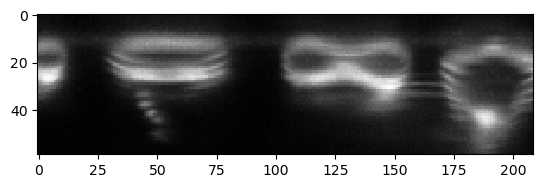

In [15]:
cle.imshow(deskewed[:,200])

In [28]:
import math
#Defining Deskewing
scale_factor = 1 #Scale factor is used in clesperanto if we want to scale the images in case they don't fit in memory


#initialise a transform
deskew_transform_1 =cle.AffineTransform3D()


#Shear
shear_factor = math.sin((90 - deskewing_angle_in_degrees) * math.pi / 180.0) * (voxel_size_z_anisotropic/voxel_size_y_in_microns)
deskew_transform_1._matrix[1, 2] = shear_factor


deskewed_1 = cle.affine_transform(source= image_anisotropic,transform = deskew_transform_1,auto_size=True,linear_interpolation=True)

print(deskewed_1.shape)



deskew_transform_2 = cle.AffineTransform3D()

#Scale to be isotropic
new_dz = math.sin(deskewing_angle_in_degrees * math.pi / 180.0) * voxel_size_z_anisotropic
scale_factor_z = (new_dz / voxel_size_y_in_microns) * scale_factor
deskew_transform_2.scale(scale_x=scale_factor, scale_y=scale_factor, scale_z=scale_factor_z)

#Rotate deskewing angle
deskew_transform_2.rotate(angle_in_degrees = 0 - deskewing_angle_in_degrees, axis=0)

deskewed_2 = cle.affine_transform(source= deskewed_1,transform = deskew_transform_2,auto_size=True,linear_interpolation=True)
print(deskewed_2.shape)


(38, 390, 209)
(331, 416, 209)


In [27]:
import napari 

viewer = napari.Viewer()
viewer.add_image(deskewed_2)

c:\Users\deepu\Anaconda3\envs\napari_lattice\lib\site-packages\napari_tools_menu\__init__.py:194: FutureWarning: Public access to Window.qt_viewer is deprecated and will be removed in
v0.5.0. It is considered an "implementation detail" of the napari
application, not part of the napari viewer model. If your use case
requires access to qt_viewer, please open an issue to discuss.
  self.tools_menu = ToolsMenu(self, self.qt_viewer.viewer)


<Image layer 'deskewed_2' at 0x25810349100>

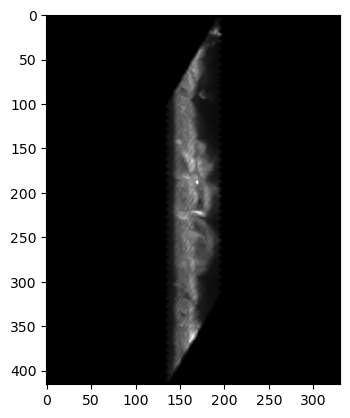

In [29]:
#Data is deskewed but not cropped
cle.imshow(cle.maximum_x_projection(deskewed_2))

In [32]:
#Scale and then deskew

import math
#Defining Deskewing
scale_factor = 1 #Scale factor is used in clesperanto if we want to scale the images in case they don't fit in memory

scale_transform = cle.AffineTransform3D()
scale_factor_z = (voxel_size_z_anisotropic / voxel_size_y_in_microns) * scale_factor

scale_transform.scale(scale_x=scale_factor, scale_y=scale_factor, scale_z=scale_factor_z)
scaled_image = cle.affine_transform(source= image_anisotropic,transform = scale_transform,auto_size=True,linear_interpolation=True)


#initialise a transform
deskew_transform_1 =cle.AffineTransform3D()


#Shear
shear_factor = math.sin((90 - deskewing_angle_in_degrees) * math.pi / 180.0) #* #(voxel_size_y_in_microns/voxel_size_y_in_microns)
deskew_transform_1._matrix[1, 2] = shear_factor

#Match scaling
new_dz = math.sin(deskewing_angle_in_degrees * math.pi / 180.0) * voxel_size_y_in_microns
scale_factor_z = (new_dz / voxel_size_y_in_microns) * scale_factor
deskew_transform_1.scale(scale_x=scale_factor, scale_y=scale_factor, scale_z=scale_factor_z)

#Rotate deskewing angle
deskew_transform_1.rotate(angle_in_degrees = 0 - deskewing_angle_in_degrees, axis=0)

deskewed_2 = cle.affine_transform(source= scaled_image,transform = deskew_transform_1,auto_size=True,linear_interpolation=True)
print(deskewed_2.shape)


(59, 416, 209)


In [35]:
new_dz

0.07249609999999998

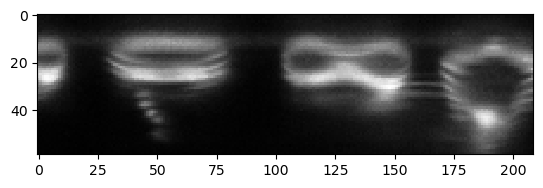

In [33]:
cle.imshow(deskewed_2[:,200])

In [31]:
import napari 

viewer = napari.Viewer()
viewer.add_image(scaled_image)

c:\Users\deepu\Anaconda3\envs\napari_lattice\lib\site-packages\napari_tools_menu\__init__.py:194: FutureWarning: Public access to Window.qt_viewer is deprecated and will be removed in
v0.5.0. It is considered an "implementation detail" of the napari
application, not part of the napari viewer model. If your use case
requires access to qt_viewer, please open an issue to discuss.
  self.tools_menu = ToolsMenu(self, self.qt_viewer.viewer)


<Image layer 'scaled_image' at 0x258141ff400>

Text(0.5, 1.0, 'OPM deskewed image')

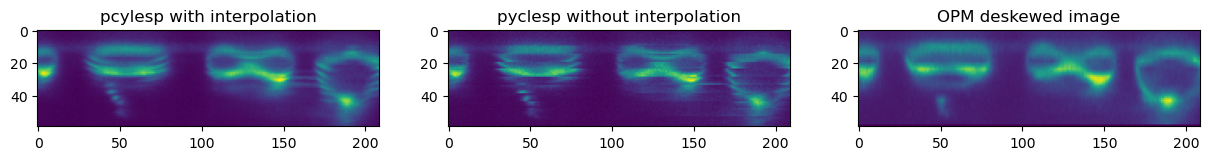

In [5]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,3, figsize=(15,8))

ax[0].imshow(deskewed_cle_anisotropic[:,200])
ax[0].set_title("pcylesp with interpolation")
ax[1].imshow(deskewed_cle_anisotropic_no_interpolation[:,200])
ax[1].set_title("pyclesp without interpolation")
ax[2].imshow(deskewed_opm[:,200])
ax[2].set_title("OPM deskewed image")


In [6]:
viewer = napari.Viewer() 
viewer.add_image(image_anisotropic, name='anisotropic image')
viewer.add_image(deskewed_cle_anisotropic, name='deskewed cle image')
viewer.add_image(deskewed_opm, name='deskewed OPM image')


c:\Users\deepu\Anaconda3\envs\napari_lattice\lib\weakref.py:370: RuntimeWarning: coroutine 'get_msg' was never awaited
  def remove(k, selfref=ref(self)):
c:\Users\deepu\Anaconda3\envs\napari_lattice\lib\site-packages\napari_tools_menu\__init__.py:194: FutureWarning: Public access to Window.qt_viewer is deprecated and will be removed in
v0.5.0. It is considered an "implementation detail" of the napari
application, not part of the napari viewer model. If your use case
requires access to qt_viewer, please open an issue to discuss.
  self.tools_menu = ToolsMenu(self, self.qt_viewer.viewer)


<Image layer 'deskewed OPM image' at 0x1b68eb21d30>